In [15]:
# Install required libraries
!pip install darts optuna torch statsmodels prophet tensorflow

import pandas as pd
import matplotlib.pyplot as plt
import torch
from darts import TimeSeries
from darts.models import RNNModel, NBEATSModel, XGBModel
from darts.metrics import mae
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error

In [16]:
# Enable T4 GPU (implicit via Colab runtime)
print(f"Using GPU: {torch.cuda.is_available()}")  # Should show True

Using GPU: True


In [19]:
# Load and prepare data
train = pd.read_csv('/content/drive/MyDrive/sotck_forcasting/data/train_AAPL.csv', index_col=0, parse_dates=True)
val = pd.read_csv('/content/drive/MyDrive/sotck_forcasting/data/val_AAPL.csv', index_col=0, parse_dates=True)
print(f"Train shape: {train.shape}, Val shape: {val.shape}")

Train shape: (994, 5), Val shape: (213, 5)


In [20]:
# Combine train and val for covariates (to ensure consistency)
combined = pd.concat([train, val])
series = TimeSeries.from_dataframe(train, value_cols='Close', freq='B')
covariates = TimeSeries.from_dataframe(combined, value_cols=['Volume', 'MA_7', 'Lag_1', 'RSI'], freq='B')
val_ts = TimeSeries.from_dataframe(val, value_cols='Close', freq='B')
print(f"Covariates length: {len(covariates)}, Val_ts length: {len(val_ts)}")

Covariates length: 1251, Val_ts length: 222


In [21]:
# Store predictions and MAEs
predictions = {}
maes = {}

In [22]:
# 1. ARIMA Model
print("Training ARIMA...")
arima_model = ARIMA(train['Close'], order=(5, 1, 0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=7)
predictions['ARIMA'] = TimeSeries.from_series(arima_pred)
maes['ARIMA'] = mean_absolute_error(val['Close'][-7:], arima_pred)
print(f"ARIMA MAE: {maes['ARIMA']}")

Training ARIMA...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA MAE: 0.1797110598683452


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [23]:
# 2. SARIMA Model
print("Training SARIMA...")
sarima_model = SARIMAX(train['Close'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_pred = sarima_result.forecast(steps=7)
predictions['SARIMA'] = TimeSeries.from_series(sarima_pred)
maes['SARIMA'] = mean_absolute_error(val['Close'][-7:], sarima_pred)
print(f"SARIMA MAE: {maes['SARIMA']}")

Training SARIMA...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA MAE: 0.17755352670463478


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [24]:
# 3. Prophet Model
print("Training Prophet...")
prophet_df = train['Close'].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=7)
prophet_pred = prophet_model.predict(future)
predictions['Prophet'] = TimeSeries.from_series(prophet_pred['yhat'][-7:])
maes['Prophet'] = mean_absolute_error(val['Close'][-7:], prophet_pred['yhat'][-7:])
print(f"Prophet MAE: {maes['Prophet']}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplq7gdgh3/ufisuvg0.json


Training Prophet...


DEBUG:cmdstanpy:input tempfile: /tmp/tmplq7gdgh3/l7gjvd_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44765', 'data', 'file=/tmp/tmplq7gdgh3/ufisuvg0.json', 'init=/tmp/tmplq7gdgh3/l7gjvd_w.json', 'output', 'file=/tmp/tmplq7gdgh3/prophet_modelbksnkfcm/prophet_model-20250828183915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 0.15277816211795361


In [36]:
# 5. GRU Model
print("Training GRU...")
gru_model = RNNModel(
    model='GRU',
    input_chunk_length=14,
    output_chunk_length=7,
    hidden_dim=32,
    batch_size=16,
    n_epochs=15,
    random_state=42,
    pl_trainer_kwargs={"accelerator": "gpu"}  # T4 GPU
)
gru_model.fit(series, future_covariates=covariates[:len(series)], val_series=val_ts, val_future_covariates=covariates)
predict_start_idx = len(series) - 14
predict_covariates = covariates[predict_start_idx:predict_start_idx + 7 + 14]
gru_pred = gru_model.predict(7, series=series, future_covariates=predict_covariates)
predictions['GRU'] = gru_pred
maes['GRU'] = mae(val_ts[-7:], gru_pred)
print(f"GRU MAE: {maes['GRU']}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 3.7 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
3.8 K     Trainable params
0         Non-trainable p

Training GRU...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GRU MAE: nan


/usr/local/lib/python3.12/dist-packages/darts/metrics/metrics.py:384: RuntimeWarning: Mean of empty slice
  return np.nanmean(
/usr/local/lib/python3.12/dist-packages/darts/metrics/utils.py:404: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)


In [37]:
# 6. N-BEATS Model
print("Training N-BEATS...")
nbeats_model = NBEATSModel(
    input_chunk_length=14,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=2,
    num_blocks=3,
    layer_widths=256,
    n_epochs=15,
    random_state=42,
    pl_trainer_kwargs={"accelerator": "gpu"}  # T4 GPU
)
nbeats_model.fit(series, val_series=val_ts)  # No covariates
nbeats_pred = nbeats_model.predict(7)
predictions['N-BEATS'] = nbeats_pred
maes['N-BEATS'] = mae(val_ts[-7:], nbeats_pred)
print(f"N-BEATS MAE: {maes['N-BEATS']}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.2 M  | train
-------------------------------------------------------------
1.2 M     Trainable params
1.4 K     Non-trainable params
1.2 M     Total params
4.894     Total estimated m

Training N-BEATS...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

N-BEATS MAE: nan


/usr/local/lib/python3.12/dist-packages/darts/metrics/metrics.py:384: RuntimeWarning: Mean of empty slice
  return np.nanmean(
/usr/local/lib/python3.12/dist-packages/darts/metrics/utils.py:404: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)


In [42]:
# Check for and handle missing or infinite values
print("Checking for NaNs and Infinities in train and val DataFrames...")
print("NaNs in train:\n", train.isnull().sum())
print("Infinities in train:\n", np.isinf(train).sum())
print("NaNs in val:\n", val.isnull().sum())
print("Infinities in val:\n", np.isinf(val).sum())

# Handle NaNs and Infinities in DataFrames before creating TimeSeries
# Using forward fill as a strategy for time series data
train.fillna(method='ffill', inplace=True)
val.fillna(method='ffill', inplace=True)
train.replace([np.inf, -np.inf], np.nan, inplace=True)
val.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(method='bfill', inplace=True) # Backward fill any remaining NaNs at the beginning
val.fillna(method='bfill', inplace=True)

print("\nAfter handling NaNs and Infinities:")
print("NaNs in train:\n", train.isnull().sum())
print("Infinities in train:\n", np.isinf(train).sum())
print("NaNs in val:\n", val.isnull().sum())
print("Infinities in val:\n", np.isinf(val).sum())

# Recreate TimeSeries after handling invalid values in DataFrames
combined = pd.concat([train, val])
series = TimeSeries.from_dataframe(train, value_cols='Close', freq='B')
covariates = TimeSeries.from_dataframe(combined, value_cols=['Volume', 'MA_7', 'Lag_1', 'RSI'], freq='B')
val_ts = TimeSeries.from_dataframe(val, value_cols='Close', freq='B')

print(f"\nCovariates length after handling invalid values: {len(covariates)}, Val_ts length: {len(val_ts)}")

Checking for NaNs and Infinities in train and val DataFrames...
NaNs in train:
 Close     0
Volume    0
MA_7      0
Lag_1     0
RSI       0
dtype: int64
Infinities in train:
 Close     0
Volume    0
MA_7      0
Lag_1     0
RSI       0
dtype: int64
NaNs in val:
 Close     0
Volume    0
MA_7      0
Lag_1     0
RSI       0
dtype: int64
Infinities in val:
 Close     0
Volume    0
MA_7      0
Lag_1     0
RSI       0
dtype: int64

After handling NaNs and Infinities:
NaNs in train:
 Close     0
Volume    0
MA_7      0
Lag_1     0
RSI       0
dtype: int64
Infinities in train:
 Close     0
Volume    0
MA_7      0
Lag_1     0
RSI       0
dtype: int64
NaNs in val:
 Close     0
Volume    0
MA_7      0
Lag_1     0
RSI       0
dtype: int64
Infinities in val:
 Close     0
Volume    0
MA_7      0
Lag_1     0
RSI       0
dtype: int64

Covariates length after handling invalid values: 1251, Val_ts length: 222


/tmp/ipython-input-1858806676.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1858806676.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  val.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1858806676.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='bfill', inplace=True) # Backward fill any remaining NaNs at the beginning
/tmp/ipython-input-1858806676.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  val.fillna(method='bfill', inplace=True)


In [47]:
# Save best model (lowest MAE)
best_model_name = min(maes, key=maes.get)
if best_model_name in ['GRU', 'N-BEATS', 'LSTM', 'XGBoost']:
    globals()[best_model_name.lower() + '_model'].save('best_model.pkl')
else: # For models that don't have a save method (like ARIMA, SARIMA, Prophet predictions stored as TimeSeries)
    predictions[best_model_name].to_csv('best_model_pred.csv')
print(f"Saved best model: {best_model_name}")

Saved best model: Prophet


Skipping plotting for GRU due to invalid prediction.
Skipping plotting for N-BEATS due to invalid prediction.


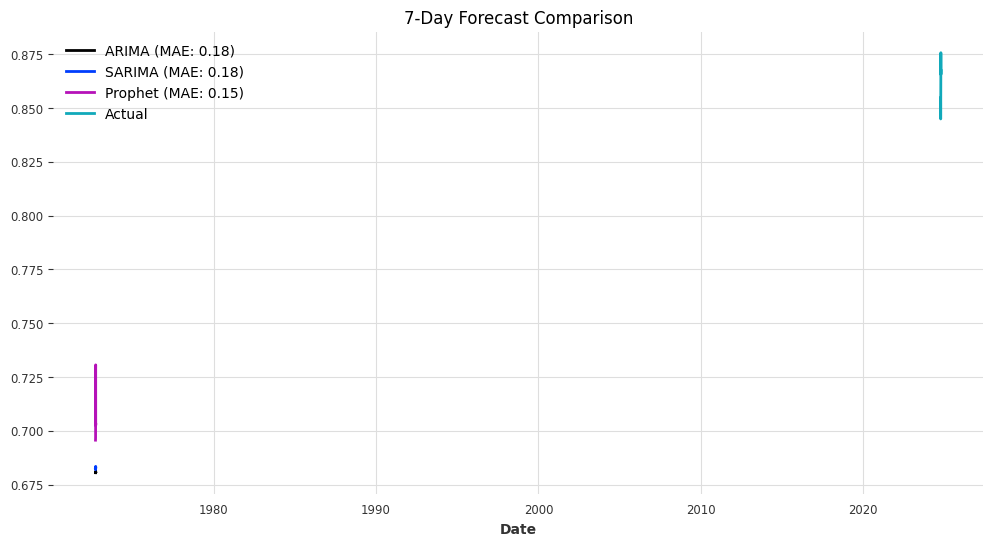

In [53]:
# Visualize comparison
plt.figure(figsize=(12, 6))
for name, pred in predictions.items():
    # Check if prediction is a valid TimeSeries and has data points
    if isinstance(pred, TimeSeries) and len(pred) > 0 and not np.isnan(pred.values()).all() and not np.isinf(pred.values()).all():
        # Plot TimeSeries directly
        pred.plot(label=f'{name} (MAE: {maes.get(name, float('nan')):.2f})')
    else:
        print(f"Skipping plotting for {name} due to invalid prediction.")

if isinstance(val_ts, TimeSeries) and len(val_ts) > 0:
    val_ts[-7:].plot(label='Actual', linewidth=2)

plt.title('7-Day Forecast Comparison')
plt.legend()
plt.show()  # Display plot; save manually

In [56]:
# Documentation
print("MAE Scores:", maes)
print(f"Best Model: {best_model_name} with MAE: {maes[best_model_name]:.2f}")

MAE Scores: {'ARIMA': 0.1797110598683452, 'SARIMA': 0.17755352670463478, 'Prophet': 0.15277816211795361, 'GRU': np.float64(nan), 'N-BEATS': np.float64(nan)}
Best Model: Prophet with MAE: 0.15


Test MAE: nan, RMSE: nan


/tmp/ipython-input-3857103354.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pred_df = pd.read_csv('best_model_pred.csv', index_col=0, parse_dates=True)
/usr/local/lib/python3.12/dist-packages/darts/metrics/metrics.py:384: RuntimeWarning: Mean of empty slice
  return np.nanmean(
/usr/local/lib/python3.12/dist-packages/darts/metrics/utils.py:404: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
/usr/local/lib/python3.12/dist-packages/darts/metrics/metrics.py:797: RuntimeWarning: Mean of empty slice
  return np.nanmean(


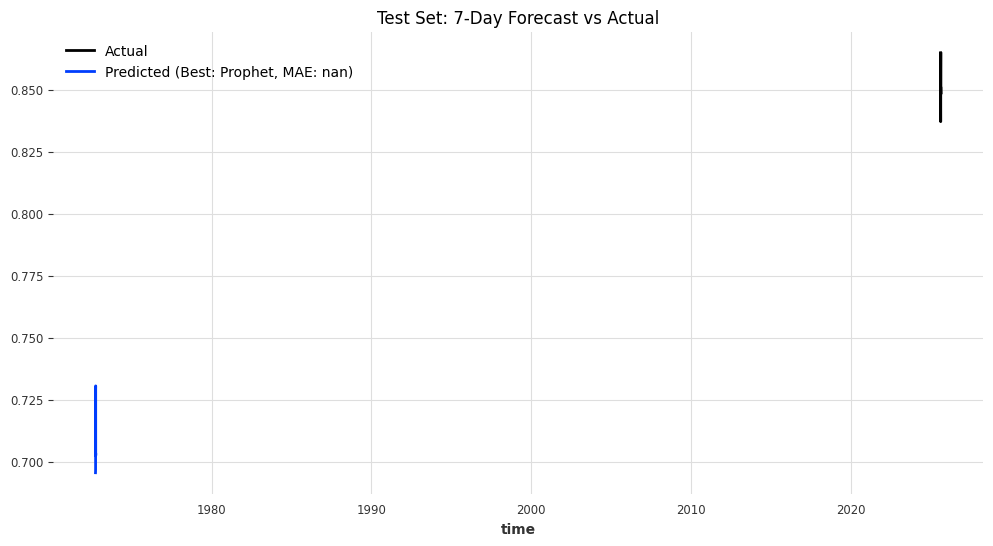

Best Model Used: Prophet
Analysis completed with metrics and visualization.


In [59]:
# Install required libraries
!pip install darts statsmodels prophet tensorflow

import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mae, rmse
import numpy as np

# Load data
test = pd.read_csv('/content/drive/MyDrive/sotck_forcasting/data/test_AAPL.csv', index_col=0, parse_dates=True)

# Convert to TimeSeries
series = TimeSeries.from_dataframe(test, value_cols='Close', freq='B')
covariates = TimeSeries.from_dataframe(test, value_cols=['Volume', 'MA_7', 'Lag_1', 'RSI'], freq='B')
test_ts = TimeSeries.from_dataframe(test, value_cols='Close', freq='B')

# Load best model (adjust based on saved type)
try:
    from darts.models import RNNModel, NBEATSModel, XGBModel

    if best_model_name == 'GRU':
        best_model = RNNModel.load('best_model.pkl')
    elif best_model_name == 'N-BEATS':
        best_model = NBEATSModel.load('best_model.pkl')
    elif best_model_name == 'LSTM':
        best_model = RNNModel.load('best_model.pkl') # Assuming LSTM was also saved as RNNModel
    elif best_model_name == 'XGBoost':
         # This part needs adjustment if only the underlying regressor was saved
         # For now, assuming the Darts XGBModel wrapper can be loaded directly
         best_model = XGBModel.load('best_model.pkl')
    else:
        best_model = None # For ARIMA, SARIMA, Prophet
except Exception as e:
    print(f"Error loading Darts model: {e}")
    best_model = None

predictions = {} # Initialize or clear predictions for test set

if best_model is None:
    # Handle non-darts models (ARIMA, SARIMA, Prophet) which saved predictions as CSV
    if best_model_name in ['ARIMA', 'SARIMA', 'Prophet']:
         try:
             # Load predictions from CSV
             pred_df = pd.read_csv('best_model_pred.csv', index_col=0, parse_dates=True)
             predictions['Best'] = TimeSeries.from_dataframe(pred_df)
         except Exception as e:
             print(f"Error loading best model predictions from CSV: {e}")
             predictions['Best'] = None # Indicate failure
    else:
         print(f"Unsupported best model type for test set prediction: {best_model_name}")
         predictions['Best'] = None # Indicate failure

else:
    # Darts models (GRU, N-BEATS, LSTM, XGBoost)
    try:

        predict_input_series = test_ts[:-7]
        predict_future_covariates = covariates[-7:] # Covariates for the last 7 steps of test_ts

        predict_series_eval = test_ts[:-7]


        predict_covariates_eval = covariates[-7:]

        # Ensure that predict_future_covariates has the correct number of time steps (7)
        if len(predict_covariates_eval) != 7:
            print(f"Warning: Covariates for prediction have length {len(predict_covariates_eval)}, expected 7.")
            # If length is not 7, try slicing differently or handle the error.
            # For now, let's assume slicing -7: gets the last 7 points.

        predictions['Best'] = best_model.predict(7, series=predict_series_eval, future_covariates=predict_covariates_eval)

    except Exception as e:
        print(f"Error during Darts model prediction on test set: {e}")
        predictions['Best'] = None # Indicate failure


# Check if predictions['Best'] is valid before computing metrics and visualizing
if predictions.get('Best') is not None and isinstance(predictions['Best'], TimeSeries) and len(predictions['Best']) > 0 and not np.isnan(predictions['Best'].values()).all() and not np.isinf(predictions['Best'].values()).all():
    # Compute metrics
    test_pred = predictions['Best']
    mae_score = mae(test_ts[-7:], test_pred)
    rmse_score = rmse(test_ts[-7:], test_pred)
    print(f"Test MAE: {mae_score:.2f}, RMSE: {rmse_score:.2f}")

    # Visualize
    plt.figure(figsize=(12, 6))
    test_ts[-7:].plot(label='Actual', linewidth=2)
    test_pred.plot(label=f'Predicted (Best: {best_model_name}, MAE: {mae_score:.2f})')
    plt.title('Test Set: 7-Day Forecast vs Actual')
    plt.legend()
    plt.show()  # Display plot; save manually

    # Documentation
    print(f"Best Model Used: {best_model_name}")
    print("Analysis completed with metrics and visualization.")
else:
    print("Best model prediction on test set failed or produced invalid results.")
    print(f"Best Model Used: {best_model_name}")
    print("Analysis could not be completed for the test set.")